# Import Files

In [189]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch

from scipy import stats

In [190]:
with open('models/residual_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('models/trend_model.pkl', 'rb') as f:
    t_model = pickle.load(f)

# Analysis of Models

## Residual Model

From the forecasted residuals, even though the residuals going to 0 is a design of an AR model with small coefficients and no intercept, we see that it does not accurately reflect reality.

Moreover, an AR(15) model is overly complicated and can be simplified much further. Hence, a different method should be used.

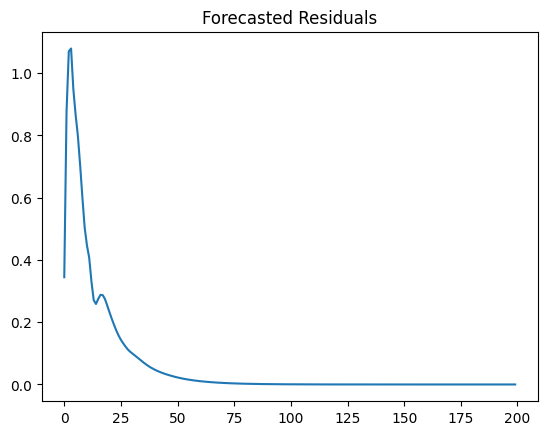

In [191]:
def get_residual_data(residual_model, forecast_t:int=0) -> np.array:
    result = residual_model.forecast(forecast_t)
    return result.values

forecast_resid = get_residual_data(r_model, 200)
plt.plot(forecast_resid)
plt.title("Forecasted Residuals")
plt.show()

## Trend & Seasonal Model Results

If we remove the residual model and plot out information regarding the residuals, we see that there is a strong partial correlation at lag 1.

In [192]:
class TemperatureModel:
    def __init__(self, trend_model, residual_model, forecast_t:int, training_periods:int=60753, latest_temp:float=19.4078):
        self.forecast_t = forecast_t
        self.latest_temp = latest_temp
        self.training_periods = training_periods
        self.trend_model = trend_model
        self.residual_model = residual_model
        
    def get_seasonal_data(self, forecast_t:int, training_periods:int=60753) -> np.array:
        t = forecast_t + training_periods
        time = np.arange(training_periods+1, t+1)
        omega = 2*np.pi/365
        ot = omega*time
        
        a = 3.4997*np.cos(ot)
        b = 2.7523*np.sin(ot)
        c = -0.3661*np.cos(2*ot)
        d = -0.1726*np.sin(2*ot)
        result = a+b+c+d
        return result
    
    def get_trend_data(self, forecast_t:int=0, latest_temp:float=19.4078, fitted_val:bool=False) -> np.array:
        standardized_forecasts = self.trend_model.fittedvalues if fitted_val else self.trend_model.forecast(forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        forecasts = standardized_forecasts*TREND_STD + TREND_MEAN
        result = latest_temp + np.cumsum(forecasts)
        return result.values
    
    def get_fitted_temps(self) -> np.array:
        self.past_trend = self.get_trend_data(fitted_val=True) 
        self.past_seasonal = self.get_seasonal_data(self.training_periods, 0)
        self.fitted_temp = self.past_seasonal[1:] + self.past_trend #Indexed to account for lag in Trend model
    
    def pipeline(self) -> np.array:
        self.seasonal = self.get_seasonal_data(self.forecast_t, self.training_periods)
        self.trend = self.get_trend_data(self.forecast_t, self.latest_temp)
        self.forecast = self.seasonal + self.trend

In [193]:
forecast = TemperatureModel(t_model, r_model, 30)
forecast.get_fitted_temps()
hist = pd.read_csv('dataset/historical_temp.csv')
residuals = hist['T_AVG'][1:].values - forecast.fitted_temp

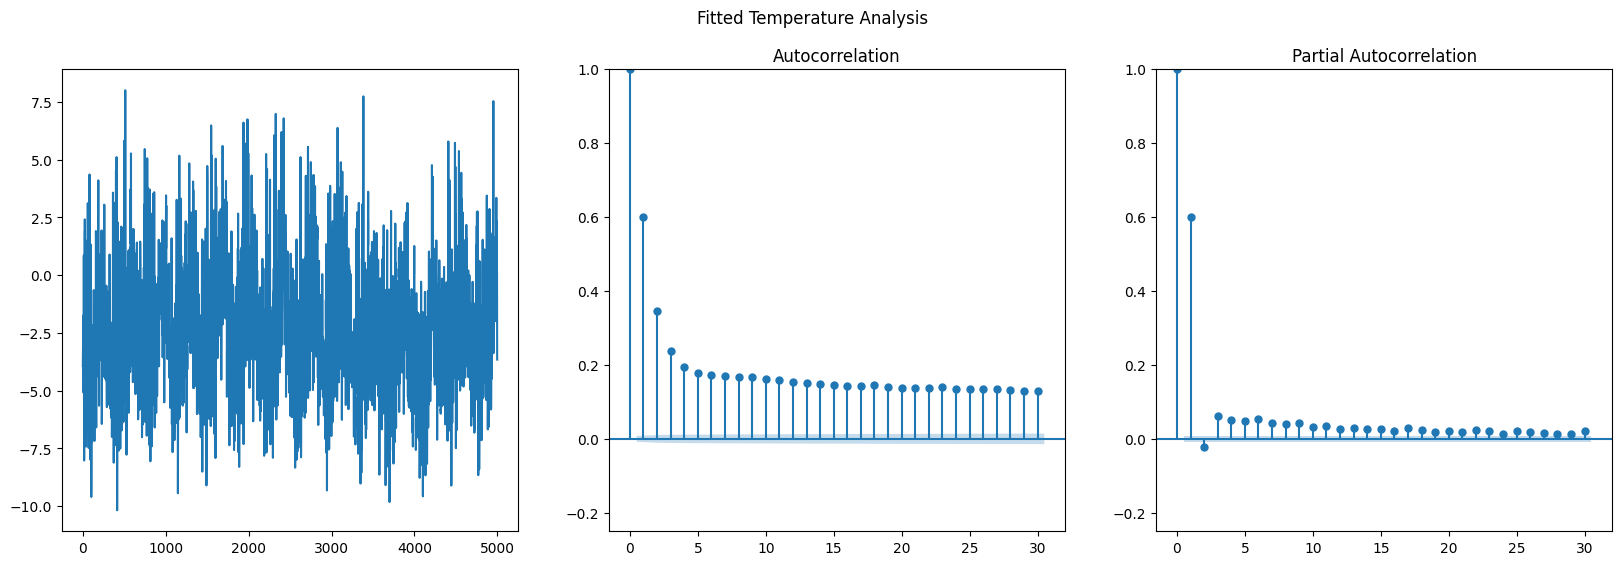

In [194]:
fig, axes = plt.subplots(ncols=3, figsize=(20,6))
fig.suptitle('Fitted Temperature Analysis')

axes[0].plot(residuals[-5000:])

plot_acf(residuals, lags=30, ax=axes[1])
axes[1].set_ylim([-0.25, 1])

plot_pacf(residuals, lags=30, ax=axes[2])
axes[2].set_ylim([-0.25, 1])

plt.show()

# Mean-Reverting Process
## Modified Ornstein Uhlenbeck
The best model to describe temperature data is a mean-reverting process, or more specifically the Ornstein-Uhlenbeck process.
$$dT_t = \kappa(\mu - T_t)dt + \sigma{dW_t}$$

If we follow the same steps to solve the Vasicek Mean-Reverting Process by letting $X_t = e^{\kappa{t}}T_t$

$$dX_t = f_{t}dt + f_{T}dT + \frac{1}{2}f_{TT}(dT)^2$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}dT + 0$$
$$dX_t = \kappa{e^{\kappa{t}}}T_tdt + e^{\kappa{t}}(\kappa(\mu - T_t)dt + \sigma{dW_t})$$
$$dX_t = \kappa\mu{e^{\kappa{t}}}dt + \sigma{e^{\kappa{t}}}{dW_t}$$

Now, instead of setting the origin to be 0, we will use $s$ to model a reversion to a changing mean temperature by assuming that temperature follows a Markov chain:
$$X_t - X_s = \kappa{\int_{s}^{t}e^{\kappa{u}}}\mu{du} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

We also need to change $du$ to $d\bar{T}$ by letting $\bar{T} = \kappa{\mu}$:
$$X_t - X_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$

Afterwards, we can further simplify to:
$$e^{\kappa{t}}T_t - e^{\kappa{s}}T_s = {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$e^{\kappa{t}}T_t = e^{\kappa{s}}T_s + {\int_{s}^{t}e^{\kappa{u}}}{d\bar{T_u}}+ \sigma{\int_{s}^{t}e^{\kappa{u}}}{dW_u}$$
$$T_t = e^{\kappa(s-t)}T_s + {\int_{s}^{t}e^{\kappa(u-t)}}{d\bar{T_u}} + \sigma{\int_{s}^{t}e^{\kappa(u-t)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + [e^{-\kappa(t-u)}\bar{T_u}]^t_s+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = e^{-\kappa(t-s)}T_s + [\bar{T_t} - \bar{T_s}e^{-\kappa(t-s)}]+ \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \sigma{\int_{s}^{t}e^{-\kappa(t-u)}}{dW_u}$$

Therefore, the temperature process reverts to a non-constant $\bar{T}$:
$$E[T_t] = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)}$$

In order to adjust the OU process, we have to add a term $\frac{d\bar{T}}{dt}$.
$$dT_t = [\frac{d\bar{T}}{dt} + \kappa(\bar{T}_t - T_t)]dt + \sigma_t{dW_t}$$

The SDE can be solved by multiplying the equation by $e^{\kappa{t}}$, which we will represent as $m$:
$$mdT_u = m{d\bar{T}_u} + m\kappa(\bar{T}_u - T_u)du + m\sigma_t{dW_u}$$
$$mdT_u + m\kappa{T_u}du = m{d\bar{T}_u} + m\kappa\bar{T}_udu + m\sigma_t{dW_u}$$

Notice that we get a result on the LHS and RHS an equation from Ito's product rule on $e^{\kappa{t}}T$, so we can change them to:
$$d({e^{\kappa{t}}T}) = d({e^{\kappa{t}}\bar{T}}) + e^{\kappa{t}}\sigma_t{dW_u}$$

Integrating both sides:
$$e^{\kappa{t}}T = e^{\kappa{t}}\bar{T} + \int^t_0e^{\kappa{u}}\sigma_u{dW_u}$$
$$T = \bar{T} + \int^t_0e^{\kappa(u-t)}\sigma_u{dW_u}$$

Lastly, taking expectation we get the desired result:
$$E[T] = \bar{T}$$

## Euler Discretization

Now that we have our modified OU process, we can use Euler discretization on our SDE over the interval between $t \in{[i-1, i]}$:
$$T_i - T_{i-1} = \bar{T_i} - \bar{T}_{i-1} + \kappa({\bar{T}_{i-1}} - T_{i-1}) + z_i\sigma_i$$
where $z_t$ ~ $N(0, 1)$.

Let $\hat{T}_t = T_t - \bar{T}_t$:
$$T_i - \bar{T_i} =  T_{i-1} - \bar{T}_{i-1} + \kappa({\bar{T}_{i-1}} - T_{i-1}) + z_i\sigma_i$$
$$\hat{T}_i = \hat{T}_{i-1} - \kappa(\hat{T}_{i-1}) + z_i\sigma_i$$

Let $\gamma = 1 - \kappa$:
$$\hat{T}_i = \gamma{\hat{T}_{i-1}} + \epsilon_i$$

Then, we realize that the final equation relates back to the AR(1) process identified previously in the PACF chart, which we can easily solve for $\gamma$

Let $\bar{T}_t$ represent our additive trend + seasonal model and $X_t$ represent whatever is left:
$$T_t = \bar{T}_t + X_t$$
$$T_t - \bar{T}_t = X_t$$
$$\hat{T}_t = \gamma{\hat{T}_{i-1}} + \epsilon_i$$

Therefore, an AR(1) model will give us the $\gamma$.

In [195]:
solve_for_gamma = AutoReg(residuals, lags=1, trend='n')
gamma_model_results  = solve_for_gamma.fit()
gamma = gamma_model_results.params
epsilon = gamma_model_results.resid
print(gamma_model_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                60752
Model:                     AutoReg(1)   Log Likelihood             -130029.694
Method:               Conditional MLE   S.D. of innovations              2.057
Date:                Sat, 19 Jul 2025   AIC                         260063.388
Time:                        16:48:03   BIC                         260081.417
Sample:                             1   HQIC                        260068.985
                                60752                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.8120      0.002    342.927      0.000       0.807       0.817
                                    Roots                                    
                  Real          Imaginary           M

Since the result is statistically significant and the roots is 1.2315 (>1) indicating a stationary process, we can proceed with $\kappa = 0.188$.

Therefore, our model is represented as:
$$dT_t = {d\bar{T}} + [0.188(\bar{T}_t - T_t)]dt + \sigma_t{dW_t}$$
$$\bar{T}_t = ARIMA(1,1,2) + S_t$$

In order to get $d\bar{T}$, we can simply forecast one time step for ARIMA(1,1,2). However, for $S_t$ we will have to find the first-order derivative:
$$S_t = 3.4997cos(\frac{2\pi{t}}{365}) + 2.7523sin(\frac{2\pi{t}}{365}) - 0.3661cos(\frac{4\pi{t}}{365}) - 0.1726sin(\frac{4\pi{t}}{365})$$

Let $\omega = \frac{2\pi}{365}$:
$$S'_t = -3.4997\omega{sin(\omega{t})} + 2.7523\omega{cos(\omega{t})} + 0.7322\omega{sin(2\omega{t})} - 0.3452\omega{cos(2\omega{t})}$$

However, we have yet to solve for $\sigma_t$, which could be a time-varying volatility component that we need to verify.

## Verification of White Noise Process

Based on the properties of a white noise process, we need to verify constant mean and variance. Moreover, the mean must be equal to 0 or we are introducing a deterministic drift.

Based on our analysis, we have found that:
- Constant Mean
    - There is a deterministic drift with a mean of -0.4821 that is statistically significant, but this can easily be solved by subtracting it and moving that to our trend component.
    - The mean passes the ADF test and is stationary. We can also see a mean-reverting behaviour in the charts.
- Time-Varying Volatility
    - In terms of volatility, we notice that there is level changes indicating. However, it does revert to the long-run average as confirmed by the ADF test on the rolling volatility.
    - Moreover, there is ARCH effect as based on the Engle's ARCH test as there is statistical significance to reject the null hypothesis (no ARCH effect).

Therefore, we are not dealing with a white noise process, but a time-varying mean-reverting volatility component.

In [196]:
#H0: unit root exists (non-stationary)
def print_adfuller_result(series:pd.Series):
    test = adfuller(series, autolag='AIC')
    print(f'1. ADF: {test[0]:.4f}')
    print(f'2. p-value: {test[1]:.4f}')
    print(f'3. No. Lags: {test[2]}')
    print(f'4. No. Observations Used: {test[3]} or {test[3]/len(series):.2%}')
    print('5. Critical Values:')
    for key,val in test[4].items():
        print(f'\t {key}: {val:.4f}')

In [197]:
epsilon_mu = epsilon.mean()
print(f'Mean of Residuals: {epsilon_mu}')

std = np.std(epsilon, ddof=1)
n = len(epsilon)
t_stat = epsilon_mu / (std / np.sqrt(n))
p_val = stats.t.sf(np.abs(t_stat), df=n-1) * 2
print(f"t-stat: {t_stat:.4f}, p-value: {p_val:.4f}\n")

Mean of Residuals: -0.4820996342379113
t-stat: -59.4099, p-value: 0.0000



1. ADF: -22.8956
2. p-value: 0.0000
3. No. Lags: 49
4. No. Observations Used: 60701 or 99.92%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


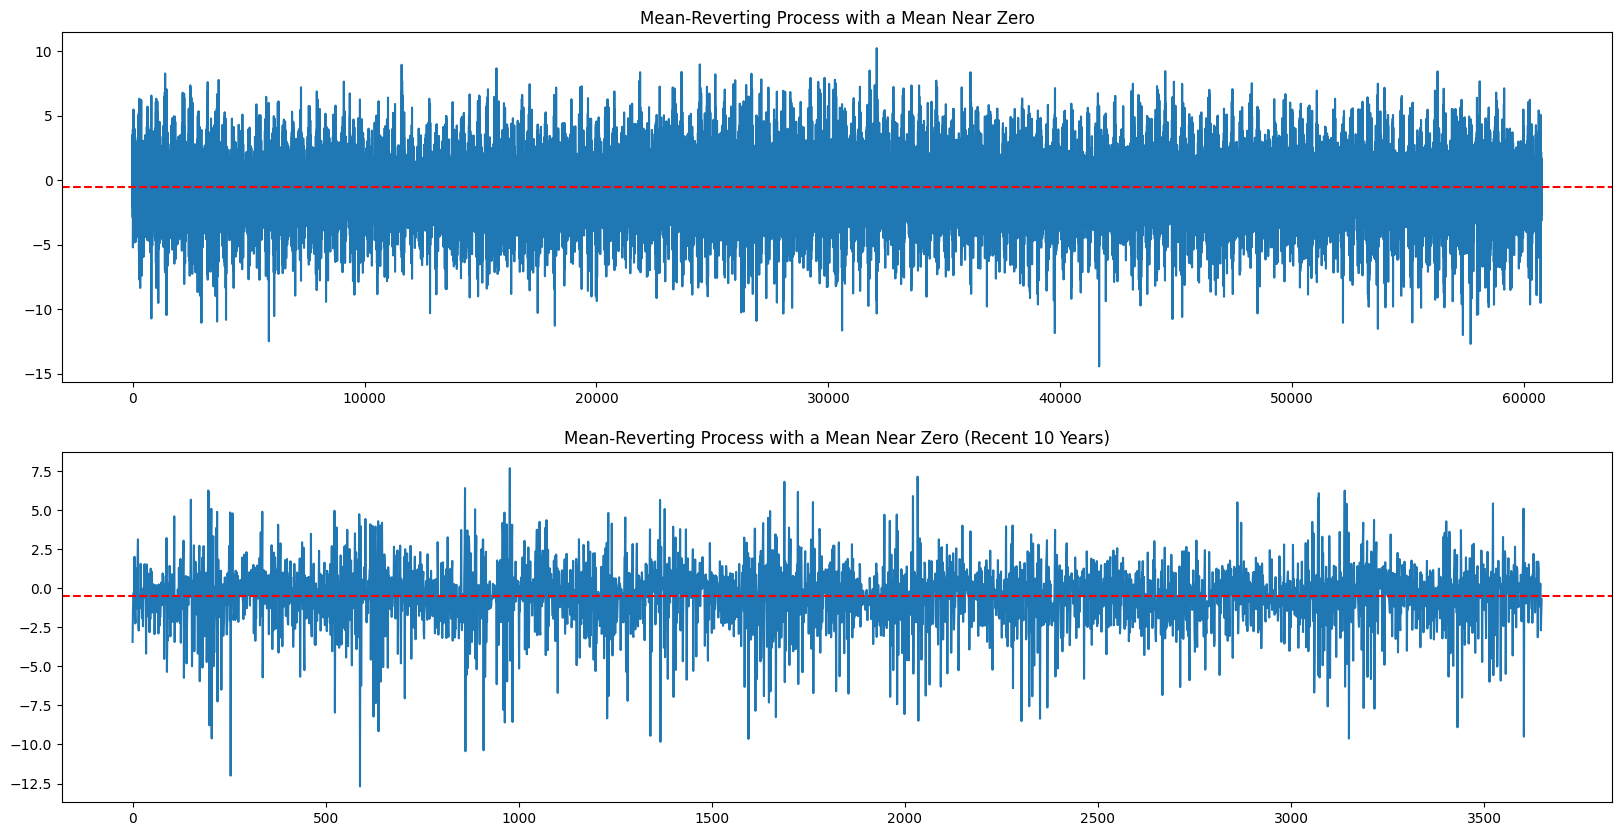

In [198]:
print_adfuller_result(epsilon)

fig, axes = plt.subplots(nrows=2, figsize=(20,10))
axes[0].plot(epsilon)
axes[0].axhline(y=epsilon_mu, linestyle='--', color='red')
axes[0].set_title('Mean-Reverting Process with a Mean Near Zero')

axes[1].plot(epsilon[-3650:])
axes[1].axhline(y=epsilon[-3650:].mean(), linestyle='--', color='red')
axes[1].set_title('Mean-Reverting Process with a Mean Near Zero (Recent 10 Years)')

plt.show()

1. ADF: -7.7826
2. p-value: 0.0000
3. No. Lags: 59
4. No. Observations Used: 60327 or 99.90%
5. Critical Values:
	 1%: -3.4305
	 5%: -2.8616
	 10%: -2.5668


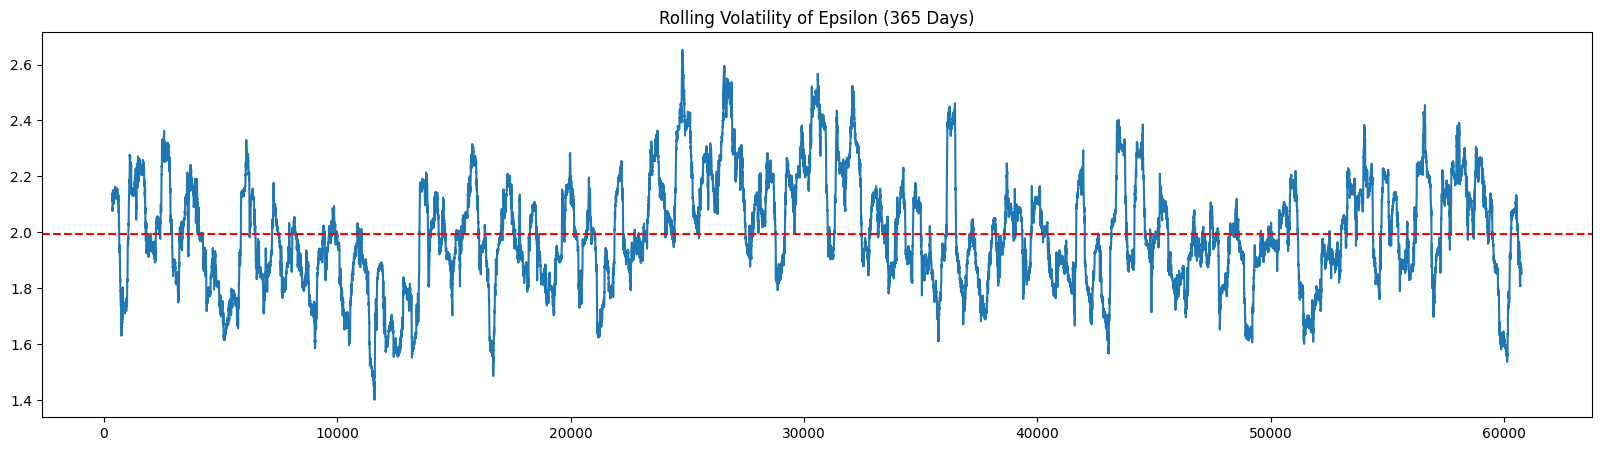

In [199]:
window = 365
rolling_std = pd.Series(epsilon).rolling(window=window).std()
print_adfuller_result(rolling_std.dropna())

plt.figure(figsize=(20, 5))
plt.plot(rolling_std)
plt.title(f'Rolling Volatility of Epsilon ({window} Days)')
plt.axhline(y=rolling_std.mean(), color='red', linestyle='--')
plt.show()

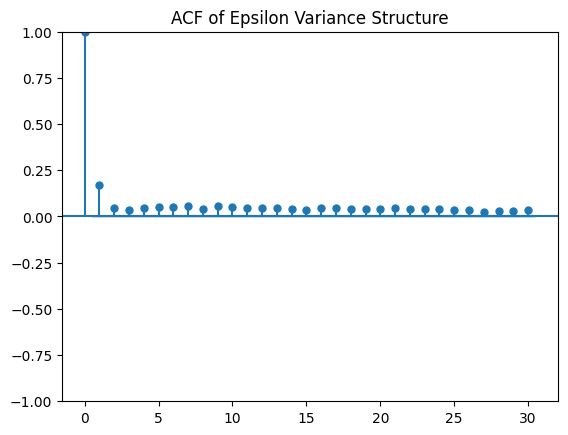

ARCH Test p-value: 0.0000


In [200]:
plot_acf(epsilon**2, lags=30) #square to look at the variance structure
plt.title('ACF of Epsilon Variance Structure')
plt.show()

#H0: No ARCH effect (constant variance)
arch_test = het_arch(epsilon, nlags= 1) #lags decided based on ACF chart
print(f"ARCH Test p-value: {arch_test[1]:.4f}")

In [201]:
sigma_bar = epsilon.std(ddof=1)
print(f'{sigma_bar:.4f}')

2.0001


## Mean-Reverting Volatility Component

In our case, we want to model volatility as a mean-reverting process as previously defined as:
$$d\sigma_t = \kappa(\bar{\sigma_t} - \sigma_t)dt + \gamma_t{dW_t}$$

Since we had previously proved that the volatility of $\epsilon_t$ is stationary, then $\bar{\sigma_t}$ is simply the long-run average standard deviation:
$$d\sigma_t = \kappa(2.0001 - \sigma_t)dt + \gamma_t{dW_t}$$

Now we apply Euler Discretization, we get:
$$\sigma_i - \sigma_{i-1} = \kappa(2.0001 - \sigma_{i-1}) + z_i\gamma_i$$
$$\sigma_i = (1-\kappa)\sigma_{i-1} + \kappa(2.0001) + z_i\gamma_i$$

Then, we can solve for $\kappa$ by fitting an AR(1) model, which we confirmed that the terms are statistically significant and that $\bar{\sigma_t}$ is close:
$$d\sigma_t = 0.0008(2.0001 - \sigma_t)dt + \gamma_t{dW_t}$$

Since the remaining residuals are in the range of -0.15 to 0.10, we can stop here as the value-add to complexity is not justified for temperature data. Therefore, we can simply use the sample standard deviation of our volatility:
$$d\sigma_t = 0.0008(2.0001 - \sigma_t)dt + 0.1934{dW_t}$$

In [202]:
mr_vol_kappa = AutoReg(rolling_std.dropna().values, lags=1, trend='c')
gamma_model_results  = mr_vol_kappa.fit()
vol_c, vol_phi = np.round(gamma_model_results.params, 4)
vol_kappa = 1-vol_phi
vol_epsilon = gamma_model_results.resid

print(f'AR(1) Constant/Kappa: {vol_c/vol_kappa:.4f}\nExpected Constant: {sigma_bar:.4f}\n')
print(gamma_model_results.summary())

AR(1) Constant/Kappa: 2.0000
Expected Constant: 2.0001

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                60387
Model:                     AutoReg(1)   Log Likelihood              207961.579
Method:               Conditional MLE   S.D. of innovations              0.008
Date:                Sat, 19 Jul 2025   AIC                        -415917.157
Time:                        16:48:28   BIC                        -415890.132
Sample:                             1   HQIC                       -415908.765
                                60387                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.000      4.860      0.000       0.001       0.002
y.L1           0.9992      0.000   6145.813      0.000       0.999       1.

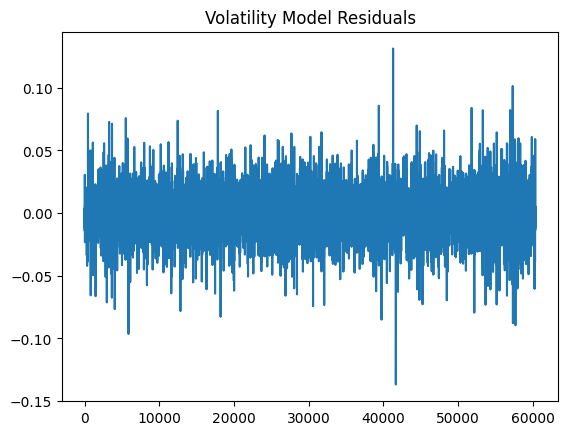

In [203]:
plt.plot(vol_epsilon)
plt.title('Volatility Model Residuals')
plt.show()

In [204]:
vol_std = round(rolling_std.std(ddof=1), 4)
print(vol_std)

0.1934


## Simulation Results

If we simulate the mean-reverting volatility process, we see that the values looks fine. However, once we include the random normally distributed z-value, the values start exploding.

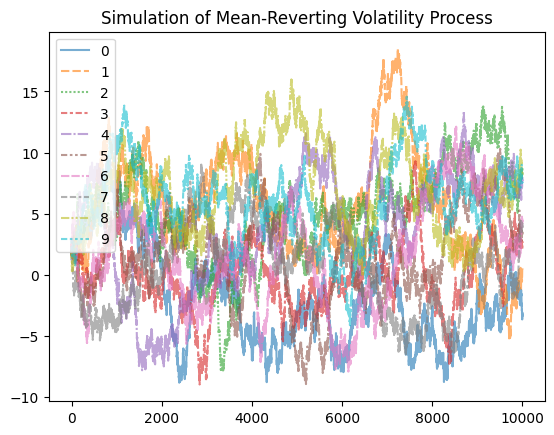

In [205]:
def volatility_ou_process(paths:int, steps:int, kappa:float=0.0008, sigma_mu:float=2.0001, eta:float=0.1934) -> np.array:
    sigma = np.zeros((paths, steps+1))
    sigma[:, 0] = sigma_mu
    for t in range(1, steps+1):
        prev_sigma = sigma[:, t-1]
        mean_reverting = kappa*(sigma_mu - prev_sigma)
        stochastic = eta*np.random.normal(0, 1, paths)
        sigma[:, t] = prev_sigma + mean_reverting + stochastic
    return sigma

vol_path = pd.DataFrame(volatility_ou_process(10, 10000)).T
sns.lineplot(vol_path, alpha=0.6)
plt.title('Simulation of Mean-Reverting Volatility Process')
plt.show()

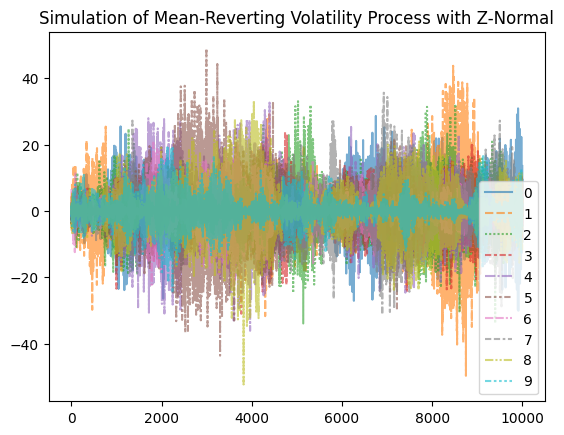

In [206]:
sims = 10
paths = 10000
vol_path = pd.DataFrame(np.random.normal(0, 1, (sims, paths+1))*volatility_ou_process(sims, paths)).T
sns.lineplot(vol_path, alpha=0.6)
plt.title('Simulation of Mean-Reverting Volatility Process with Z-Normal')
plt.show()

Moreover, if we look at the simulated Modified OU Temperature process, we see that the stochastic component dominates the resulting temperature. However, once we increased the mean-reverting speed, our data looks more reflective of real-world temperature for Sydney.

In [207]:
class TemperatureModel:
    def __init__(self, trend_model, forecast_t:int, latest_temp:float=19.4078):
        self.trend_model = trend_model
        self.latest_temp = latest_temp
        self.forecast_t = forecast_t
        
    def trend_component(self) -> np.array:
        standardized_forecasts = self.trend_model.forecast(self.forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        trend_change = standardized_forecasts*TREND_STD + TREND_MEAN
        return trend_change.values

    def seasonal_component(self, training_periods:int=60753) -> np.array:
        end = self.forecast_t + training_periods
        time = np.arange(training_periods+1, end+1)
        omega = 2*np.pi/365
        ot= omega*time
        
        a = -3.4997*omega*np.sin(ot)
        b = 2.7523*omega*np.cos(ot)
        c = 0.7322*omega*np.sin(2*ot)
        d = -0.3452*omega*np.cos(2*ot)
        
        seasonal_change = a+b+c+d
        return seasonal_change
    
    def volatility_ou_process(self, paths:int, kappa:float=0.0008, sigma_mu:float=2.0001, eta:float=0.1934) -> np.array:
        sigma = np.zeros((paths, self.forecast_t+1))
        sigma[:, 0] = sigma_mu
        for t in range(1, self.forecast_t+1):
            prev_sigma = sigma[:, t-1]
            mean_reverting = kappa*(sigma_mu - prev_sigma)
            stochastic = eta*np.random.normal(0, 1, paths)
            sigma[:, t] = prev_sigma + mean_reverting + stochastic
        return sigma
    
    def temperature_ou_process(self, paths:int, kappa_t:float=0.188, kappa_v:float=0.0008) -> np.array:
        temperature = np.zeros((paths, self.forecast_t+1))
        temperature[:, 0] = self.latest_temp
        
        trend_change = self.trend_component()
        seasonal_change = self.seasonal_component()
        T_bar = np.concatenate([[self.latest_temp], self.latest_temp + np.cumsum(trend_change+seasonal_change)])
        dT_bar = np.diff(T_bar, prepend=T_bar[0])
        sigma = self.volatility_ou_process(paths, kappa_v)
        
        self.temp = []
        for t in range(1, self.forecast_t+1):
            prev_temp = temperature[:, t-1]
            mean_reverting = kappa_t*(T_bar[t-1]-prev_temp)
            deterministic = dT_bar[t] + mean_reverting
            
            z = np.random.normal(0, 1, paths)
            stochastic = z*sigma[:, t]
            temperature[:, t] = prev_temp + deterministic + stochastic
            self.temp.append([prev_temp[0], deterministic[0], stochastic[0], z[0], sigma[0, t]])
        
        return temperature

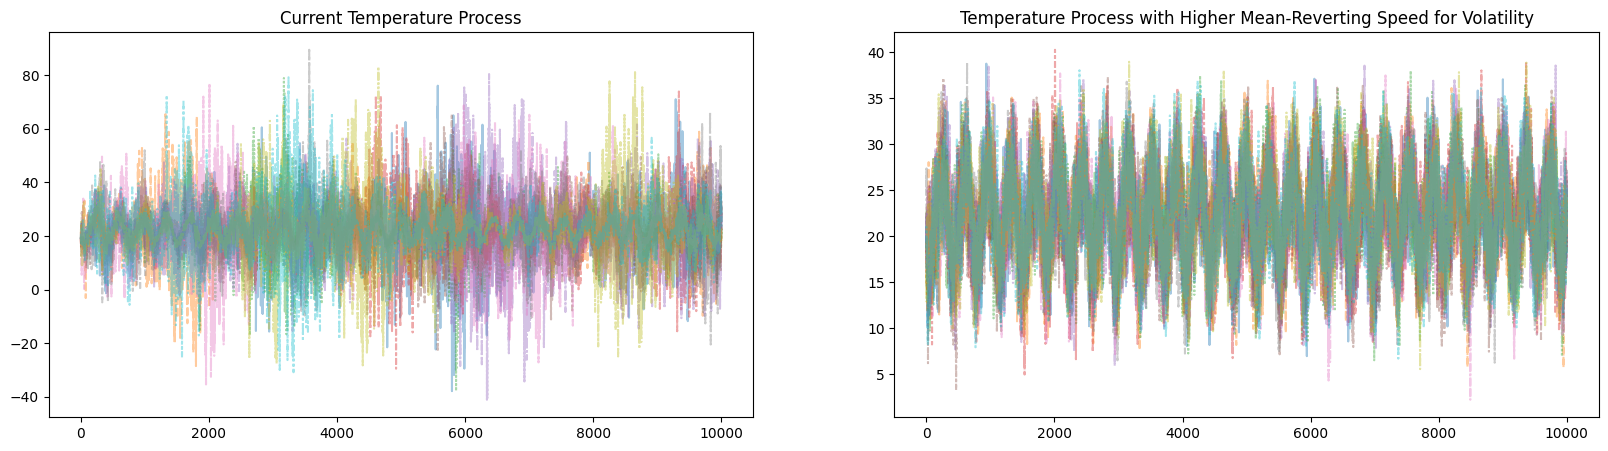

In [208]:
tm = TemperatureModel(t_model, 10000)
sim_1 = pd.DataFrame(tm.temperature_ou_process(10).T)
sim_2 = pd.DataFrame(tm.temperature_ou_process(10, kappa_v=0.3)).T

fig, axes = plt.subplots(ncols=2, figsize=(20,5))
sns.lineplot(sim_1, alpha=0.4, linestyle='--', ax=axes[0], legend=False)
axes[0].set_title('Current Temperature Process')
sns.lineplot(sim_2, alpha=0.4, linestyle='--', ax=axes[1], legend=False)
axes[1].set_title('Temperature Process with Higher Mean-Reverting Speed for Volatility')

plt.show()

## Improvement of the Parameters for the Volatility Model

Once again, we want to model volatility as a mean-reverting process as previously defined as:
$$d\sigma_t = \kappa(\bar{\sigma_t} - \sigma_t)dt + \gamma_t{dW_t}$$

It is likely that the rolling window set at 365 was too long and smoothed the data too much. Typically, we would use the intraday values to get the daily volatility measure, but that is not available. Therefore, we will try a shorter window of one week.

In [209]:
rolling_std = pd.Series(epsilon).rolling(window=7).std()
mr_vol_kappa = AutoReg(rolling_std.dropna().values, lags=1, trend='c')
gamma_model_results  = mr_vol_kappa.fit()
vol_c, vol_phi = np.round(gamma_model_results.params, 4)
vol_kappa = 1-vol_phi
print(gamma_model_results.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                60745
Model:                     AutoReg(1)   Log Likelihood              -27780.034
Method:               Conditional MLE   S.D. of innovations              0.382
Date:                Sat, 19 Jul 2025   AIC                          55566.067
Time:                        16:48:33   BIC                          55593.111
Sample:                             1   HQIC                         55574.462
                                60745                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1652      0.003     47.412      0.000       0.158       0.172
y.L1           0.9118      0.002    547.092      0.000       0.908       0.915
                                    Roots           

In [210]:
historical_data = hist.copy()
historical_data.set_index('Date', inplace=True)
historical_data.index = pd.to_datetime(historical_data.index)

orig_data_end_date = pd.to_datetime('2025-05-02')
prev_year = historical_data.loc[historical_data.index >= (orig_data_end_date - pd.DateOffset(years=3))]
prev_year.head(5)

,T_AVG
Date,
2022-05-02,18.05
2022-05-03,18.95
2022-05-04,20.05
2022-05-05,19.45
2022-05-06,16.40


From our simulation paths, we see that it is not too drastically different from the historical path. However, based on the 95% Confidence Interval band, we note that our simulation constantly overestimates the hotter temperatures. This is likely due to the Modified OU process where our model reverts to an increasing average temperature attributed to climate change. Hence, this behaviour is by design.

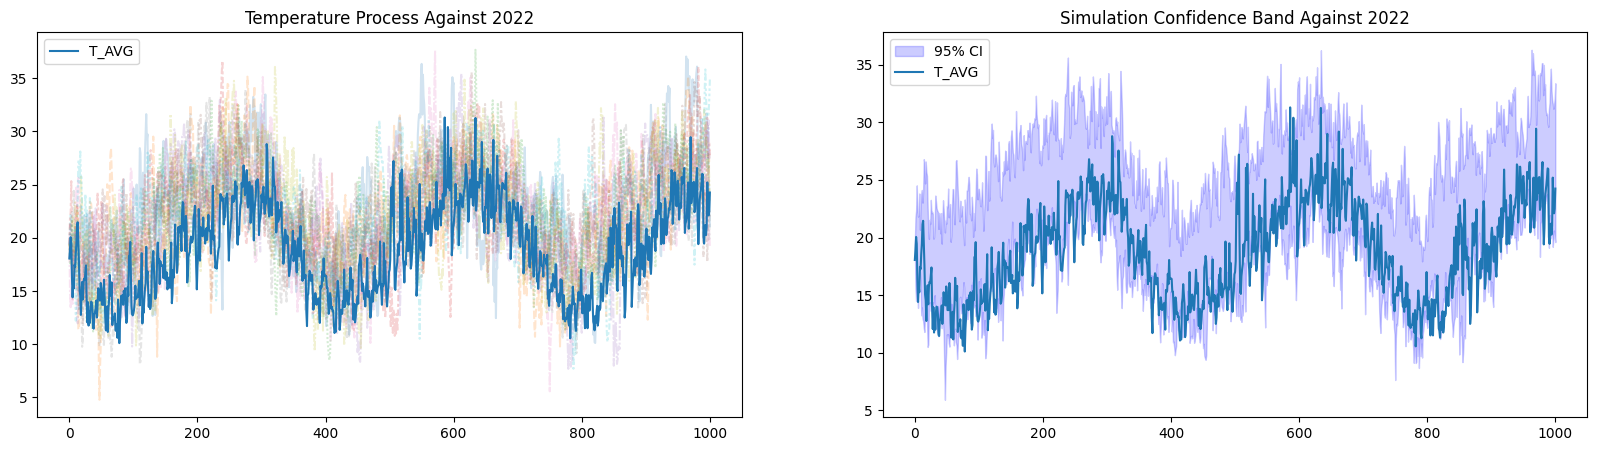

In [211]:
paths, steps = 10, 1000
tm = TemperatureModel(t_model, steps)
sim = pd.DataFrame(tm.temperature_ou_process(paths, kappa_v=vol_kappa)).T
filter_prev_year = prev_year.iloc[:steps+1]
filter_prev_year.index = range(0, steps+1)

fig, axes = plt.subplots(ncols=2, figsize=(20,5))
sns.lineplot(sim, alpha=0.2, linestyle='--', legend=False, ax=axes[0])
sns.lineplot(filter_prev_year, ax=axes[0])
axes[0].set_title('Temperature Process Against 2022')

ci_lower = sim.quantile(0.025, axis=1)
ci_upper = sim.quantile(0.975, axis=1)
axes[1].fill_between(filter_prev_year.index, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
sns.lineplot(filter_prev_year, ax=axes[1])
axes[1].set_title('Simulation Confidence Band Against 2022')

plt.show()

In [212]:
def create_month_features(target_df:pd.DataFrame) -> pd.DataFrame:
    df = target_df.copy()
    df['month'] = df.index.month
    mask = (df['month'] >= 5) & (df['month'] <= 10)
    df['winter'] = np.where(mask, 1, 0)
    df['summer'] = np.where(df['winter'] != 1, 1, 0)
    return df

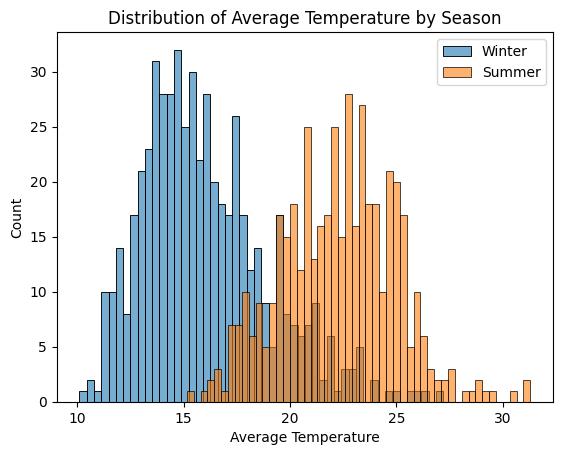

In [213]:
historical_data = create_month_features(historical_data)
prev_year = historical_data.loc[historical_data.index >= (orig_data_end_date - pd.DateOffset(years=3))]
filter_prev_year = prev_year.iloc[:steps]

winter_data = filter_prev_year.loc[filter_prev_year['winter'] == 1, 'T_AVG']
summer_data = filter_prev_year.loc[filter_prev_year['summer'] == 1, 'T_AVG']

sns.histplot(data=winter_data, alpha=0.6, bins=50)
sns.histplot(data=summer_data, alpha=0.6, bins=50)
plt.title('Distribution of Average Temperature by Season')
plt.xlabel('Average Temperature')
plt.legend(['Winter', 'Summer'])
plt.show()

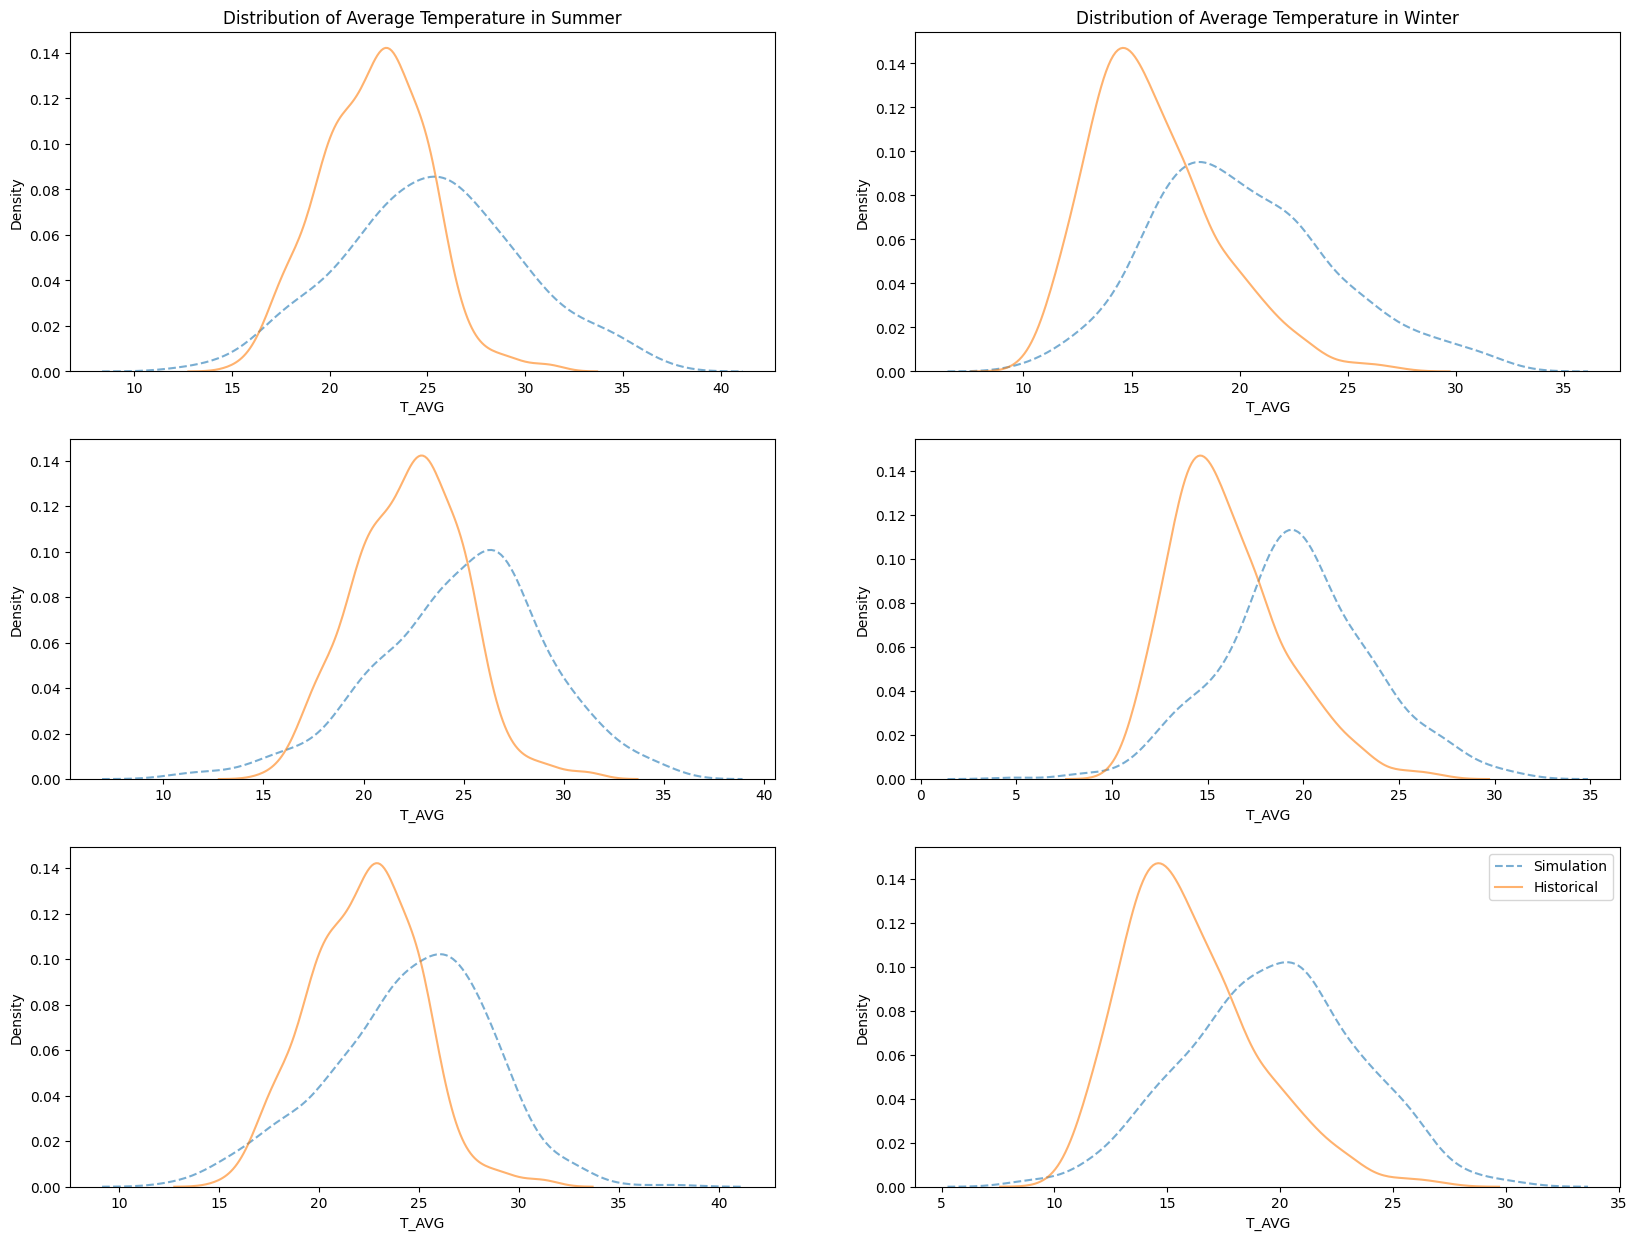

In [214]:
fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(20,15))

for i in range(3):
    last_sim = sim.iloc[:, [i]].copy()
    last_sim.columns = ['T_AVG']
    last_sim.index = pd.date_range(start=orig_data_end_date, periods=steps+1, freq='D') 
    sim_df = create_month_features(last_sim)
    
    winter_sim = sim_df.loc[sim_df['winter'] == 1, 'T_AVG']
    summer_sim = sim_df.loc[sim_df['summer'] == 1, 'T_AVG']
    
    sns.kdeplot(data=summer_sim, alpha=0.6, linestyle='--', ax=axes[i, 0])
    sns.kdeplot(data=summer_data, alpha=0.6, ax=axes[i, 0])
    
    sns.kdeplot(data=winter_sim, alpha=0.6, linestyle='--', ax=axes[i, 1])
    sns.kdeplot(data=winter_data, alpha=0.6, ax=axes[i, 1])
    

axes[0, 0].set_title('Distribution of Average Temperature in Summer')
axes[0, 1].set_title('Distribution of Average Temperature in Winter')

plt.legend(['Simulation', 'Historical'])
plt.show()

Therefore, our new equation will be:
$$d\sigma_t = 0.0882(2.0001 - \sigma_t)dt + 0.1934{dW_t}$$

# Pricing Weather Derivatives

## Comparitive Pricing Method using Risk-Neutral Measure
Let $\lambda\sigma_t$ be the market price of risk and Q be the Martingale measure:
$$dT_t = [\frac{d\bar{T}}{dt} + \kappa(\bar{T}-T_t)]dt + \sigma_{t}(dW^Q_t - \lambda{dt})$$
$$dT_t = [\frac{d\bar{T}}{dt} + \kappa(\bar{T}-T_t) - \lambda\sigma_t]dt + \sigma_{t}dW^Q_t$$

From the solution to our SDE, we can get the variance through Isometry Theorem:
$$T = \bar{T} + \int^t_0e^{\kappa(u-t)}\sigma_u{dW_u}$$
$$V^P[T_t | \mathcal{F}_s] = \int^t_s\sigma^2_ue^{2\kappa(u-t)}du$$

Based on the original OU temperature process, we had essentially solved the conditional expectation of $T_t$ given the available information at time s:
$$E^P[T_t | \mathcal{F}_s] = \bar{T}_t + (T_s - \bar{T_s})e^{-\kappa(t-s)}$$

Therefore, we should work from the original OU process solution:
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \int_{s}^{t}\sigma_{u}e^{-\kappa(t-u)}dW_u$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} + \int_{s}^{t}\sigma_{u}e^{-\kappa(t-u)}(dW^Q_t - \lambda{du})$$
$$T_t = \bar{T_t} + (T_s - \bar{T_s})e^{-\kappa(t-s)} - \int_{s}^{t}\lambda\sigma_{u}e^{-\kappa(t-u)}du + \int_{s}^{t}\sigma_{u}e^{-\kappa(t-u)}dW^Q_t$$

Hence, we get the following values:
$$E^Q[T_t | \mathcal{F}_s] = \bar{T}_t + (T_s - \bar{T_s})e^{-\kappa(t-s)} - \int_{s}^{t}\lambda\sigma_{u}e^{-\kappa(t-u)}du$$
$$E^Q[T_t | \mathcal{F}_s] = E^P[T_t | \mathcal{F}_s] - \int_{s}^{t}\lambda\sigma_{u}e^{-\kappa(t-u)}du$$
$$V^Q[T_t | \mathcal{F}_s] = \int^t_s\sigma^2_ue^{-2\kappa(t-u)}du$$

When evaluating the integrals, we will make an assumption that there is a time interval where $\sigma_i$ is constant:
$$E^Q[T_t | \mathcal{F}_s] = E^P[T_t | \mathcal{F}_s] - \frac{\lambda\sigma_i}{\kappa}[e^{-\kappa(t-u)}]^t_s$$
$$E^Q[T_t | \mathcal{F}_s] = E^P[T_t | \mathcal{F}_s] - \frac{\lambda\sigma_i}{\kappa}[1 - e^{-\kappa(t-s)}]$$
$$V^Q[T_t | \mathcal{F}_s] = \frac{\sigma^2_i}{2\kappa}[1-e^{-2\kappa(t-s)}]$$

Then, under the condition that $0 \le s \le t \le u$, the covariance of a mean-reverting process given the available information at time s can be denoted by:
$$Cov[T_t, T_u | \mathcal{F}_s] = e^{-\kappa(u-t)}V[T_t | \mathcal{F_s}]$$

A HDD call option payoff is given by:
$$C = MIN(\alpha(H_n - K)^+, Cap)$$
where $\alpha$ is the payoff rate, K is the strike, Cap is the maximum payout and $H_n$ is given by:
$$H_n = \sum^n_{i=1}(18 - T_i)^+$$

Here we note that $H_n$ is causing an issue as it is not normally distributed due to the abrupt cutoff. Hence, we are not able to simply plug the Risk-Neutral Pricing formula. Nonetheless, our aim is to evaluate the effectiveness of our Monte Carlo Simulation, so we shall make the naive assumption that the probability that our daily average temperature going above 18 during Winter is infinitesimally small and therefore negligible.

$$H_n = 18n - \sum^n_{i=1}T_i$$

In reality, we can see from the charts above that that is not the case. However, we can set the derived pricing as our baseline and since we know that this will underestimate the actual price, we can set the condition that our Monte Carlo Valuation is considered effective if the resulting price is above this baseline.

Moreover, since the OU process is inherently Gaussian, the sum will naturally mean that $H_n$ is normally distributed too.
$$ E^Q[H_n | \mathcal{F}_t] = E^Q[18n - \sum^n_{i=1}T_i | \mathcal{F}_t]$$
$$\mu_n = 18n - \sum^n_{i=1}E^Q[T_i | \mathcal{F}_t]$$

$$V^Q[H_n | \mathcal{F}_t] = V^Q[\sum^n_{i=1}T_i | \mathcal{F}_t]$$
$$\sigma^2_n = \sum^n_{i=1}V^Q[T_i | \mathcal{F}_t] + 2\sum_{i<j}Cov[T_i, T_j | \mathcal{F}_t]$$

$$H_n: N(\mu_n, \sigma_n)$$

Source: https://www.math.kth.se/matstat/fofu/reports/weather.pdf

In [215]:
class RiskNeutral:
    def __init__(self, duration:int, kappa:float):
        self.duration = duration
        self.kappa = kappa
        self.dt = 1/365
    
    def _calc_mean(self, t_bar:np.array, volatility:np.array, lamda:float) -> float:
        base_temp = 18*self.duration
        expectation_q = t_bar - (lamda/self.kappa)*volatility*(1-np.exp(-self.kappa*self.dt))
        return base_temp - np.sum(expectation_q)
    
    def _sum_triangle_covariance(self, var_intervals:np.array) -> float:
        cov_sum = 0
        for i in range(self.duration):
            var = var_intervals[i]
            for j in range(i+1, self.duration):
                tau = abs(j-i)*self.dt
                decay_factor = np.exp(-self.kappa*tau)
                cov_sum += decay_factor*var
        return cov_sum
    
    def _calc_var(self, volatility:np.array) -> float:
        variance = np.square(volatility)
        var_intervals = variance/(2*self.kappa)* (1-np.exp(-2*self.kappa*self.dt))
        cov_sum = self._sum_triangle_covariance(self.duration, self.kappa, var_intervals)
        return np.sum(var_intervals) + 2*cov_sum
    
    def compute_mean_var(self, t_bar:np.array, volatility:np.array, lamda:float) -> tuple[float, float]:
        mean = self._calc_mean(t_bar, volatility, lamda)
        var = self._calc_var(volatility)
        return mean, var

### Call Option
Therefore, we get the following equation for our call option:
$$C_t = \alpha{e^{-r(T-t)}} E^Q[(H_n-K)^+ | \mathcal{F_t}]$$
$$C_t = \alpha{e^{-r(T-t)}} \int^\infty_{-\infty} (x-K)^+f_{H_n}(x)dx$$
$$C_t = \alpha{e^{-r(T-t)}} \int^\infty_K (x-K)f_{H_n}(x)dx$$

Since we know that $f_{H_n}$ is normally distributed, we get the following:
$$C_t = \frac{\alpha{e^{-r(T-t)}}}{\sigma\sqrt{2\pi}} \int^\infty_K (x-K)e^{-\frac{(x-\mu)^2}{2\sigma^2}}dx$$

Let $z = \frac{x-\mu}{\sigma}$:
$$\sigma{dz} = dx$$

This also means that as $x \to \infty$, $z \to \infty$. We also get $x \to K$, $z \to \frac{K-\mu}{\sigma} = z^*$.
$$C_t = \frac{\alpha{e^{-r(T-t)}}}{\sqrt{2\pi}} \int^\infty_{z^*} (\mu+\sigma{z}-K)e^{-\frac{z^2}{2}}dz$$
$$C_t = \alpha{e^{-r(T-t)}} [(\mu-K)\Phi(-z^*) + \frac{\sigma}{\sqrt{2\pi}}\int^\infty_{z^*} ze^{-\frac{z^2}{2}}dz]$$

Let $u = \frac{z^2}{2}$:
$$\frac{1}{z}du = dz$$

This also means that as $z \to \infty$, $u \to \infty$. We also get $z \to z^*$, $u \to \frac{(z^{*})^2}{2}$:
$$C_t = \alpha{e^{-r(T-t)}} [(\mu-K)\Phi(-z^*) + \frac{\sigma}{\sqrt{2\pi}}\int^\infty_{z^*} e^{-u}du]$$
$$C_t = \alpha{e^{-r(T-t)}} [(\mu-K)\Phi(-z^*) + \frac{\sigma}{\sqrt{2\pi}}(0 +e^{-\frac{(z^{*})^2}{2}})]$$
$$C_t = \alpha{e^{-r(T-t)}} [(\mu-K)\Phi(-z^*) + \frac{\sigma}{\sqrt{2\pi}}(e^{-\frac{(z^{*})^2}{2}})]$$

In [216]:
def call_price(payoff:int, mean:float, var:float, strike:int, time_to_expiry:int, risk_free:float) -> float:
    sigma = np.sqrt(var)
    tau = time_to_expiry/365
    z_star = (strike-mean)/sigma
    
    decay_factor = np.exp(-risk_free*tau)
    cdf = (mean-strike)*stats.norm.cdf(-z_star)
    u_component = sigma/np.sqrt(2*np.pi)* np.exp(-z_star**2/2)
    return payoff*decay_factor*(cdf + u_component)

### Put Option
Since the HDD can never be below 0, we get the following equation:
$$P_t = \alpha{e^{-r(T-t)}} E^Q[(K-H_n)^+ | \mathcal{F_t}]$$
$$P_t = \alpha{e^{-r(T-t)}} \int^K_0 (K-x)f_{H_n}(x)dx$$

As $x \to K$, $z \to \frac{K-\mu}{\sigma} = z^*$. Moreover, as $x \to 0$, $z \to -\frac{\mu}{\sigma}$:
$$P_t = \frac{\alpha{e^{-r(T-t)}}}{\sigma\sqrt{2\pi}} \int^K_0 (K-x)e^{-\frac{(x-\mu)^2}{2\sigma^2}}dx$$
$$P_t = \frac{\alpha{e^{-r(T-t)}}}{\sqrt{2\pi}} \int^{z^*}_{-\frac{\mu}{\sigma}} (K-\mu-\sigma{z})e^{-\frac{z^2}{2}}dz$$
$$P_t = \alpha{e^{-r(T-t)}}\left[(K-\mu)\left(\Phi(z^*) - \Phi(-\frac{\mu}{\sigma})\right) - \frac{\sigma}{\sqrt{2\pi}}\int^{z^*}_{-\frac{\mu}{\sigma}} ze^{-\frac{z^2}{2}}dz \right]$$

As $z \to z^*$, $u \to \frac{(z^*)^2}{2}$ and $z \to -\frac{\mu}{\sigma}$, $u \to \frac{\mu^2}{2\sigma^2}$:
$$P_t = \alpha{e^{-r(T-t)}}\left[(K-\mu)\left(\Phi(z^*) - \Phi(-\frac{\mu}{\sigma})\right) - \frac{\sigma}{\sqrt{2\pi}}\int^{\frac{(z^*)^2}{2}}_{\frac{\mu^2}{2\sigma^2}} e^{-u}du \right]$$
$$P_t = \alpha{e^{-r(T-t)}}\left[(K-\mu)\left(\Phi(z^*) - \Phi(-\frac{\mu}{\sigma})\right) + \frac{\sigma}{\sqrt{2\pi}}\left(e^{-\frac{(z^*)^2}{2}} - e^{-\frac{\mu^2}{2\sigma^2}}\right)\right]$$

In [217]:
def put_price(payoff:int, mean:float, var:float, strike:int, time_to_expiry:int, risk_free:float) -> float:
    sigma = np.sqrt(var)
    tau = time_to_expiry/365
    z_star = (strike-mean)/sigma
    
    decay_factor = np.exp(-risk_free*tau)
    cdf = (strike-mean)*(stats.norm.cdf(z_star) - stats.norm.cdf(-mean/sigma))
    u_component = sigma/np.sqrt(2*np.pi)* (np.exp(-z_star**2/2) - np.exp(-mean**2/(2*var)))
    return payoff*decay_factor*(cdf + u_component)

### Results

In [218]:
class RiskNeutral:
    def __init__(self, duration:int, kappa_t:float=0.188):
        self.duration = duration
        self.kappa = kappa_t
        self.dt = 1/365
    
    def _calc_mean(self, t_bar:np.array, volatility:np.array, lamda:float) -> float:
        base_temp = 18*self.duration
        expectation_q = t_bar - (lamda/self.kappa)*volatility*(1-np.exp(-self.kappa*self.dt))
        return base_temp - np.sum(expectation_q)
    
    def _sum_triangle_covariance(self, var_intervals:np.array) -> float:
        cov_sum = 0
        for i in range(self.duration):
            var = var_intervals[i]
            for j in range(i+1, self.duration):
                tau = abs(j-i)*self.dt
                decay_factor = np.exp(-self.kappa*tau)
                cov_sum += decay_factor*var
        return cov_sum
    
    def _calc_var(self, volatility:np.array) -> float:
        variance = np.square(volatility)
        var_intervals = variance/(2*self.kappa)* (1-np.exp(-2*self.kappa*self.dt))
        cov_sum = self._sum_triangle_covariance(var_intervals)
        return np.sum(var_intervals) + 2*cov_sum
    
    def compute_mean_var(self, t_bar:np.array, volatility:np.array, lamda:float) -> tuple[float, float]:
        mean = self._calc_mean(t_bar, volatility, lamda)
        var = self._calc_var(volatility)
        return mean, var
    
    def option_price(self, option_type:str, payoff:int, mean:float, var:float, strike:int, time_to_expiry:int, risk_free:float) -> float:
        sigma = np.sqrt(var)
        tau = time_to_expiry/365
        z_star = (strike-mean)/sigma
        
        decay_factor = np.exp(-risk_free*tau)
        
        if option_type == 'c':
            cdf = (mean-strike)*stats.norm.cdf(-z_star)
            u_component = sigma/np.sqrt(2*np.pi)* np.exp(-z_star**2/2)
        elif option_type == 'p':
            cdf = (strike-mean)*(stats.norm.cdf(z_star) - stats.norm.cdf(-mean/sigma))
            u_component = sigma/np.sqrt(2*np.pi)* (np.exp(-z_star**2/2) - np.exp(-mean**2/(2*var)))
        else:
            raise ValueError("Option type must either be 'c' or 'p'")
        
        return payoff*decay_factor*(cdf + u_component)

In [219]:
class TemperatureModel:
    def __init__(self, trend_model, forecast_t:int, latest_temp:float=19.4078):
        self.trend_model = trend_model
        self.latest_temp = latest_temp
        self.forecast_t = forecast_t
        
    def trend_component(self) -> np.array:
        standardized_forecasts = self.trend_model.forecast(self.forecast_t)
        TREND_STD = 0.0007483
        TREND_MEAN = 0.00003993
        
        trend_change = standardized_forecasts*TREND_STD + TREND_MEAN
        return trend_change.values

    def seasonal_component(self, training_periods:int=60753) -> np.array:
        end = self.forecast_t + training_periods
        time = np.arange(training_periods+1, end+1)
        omega = 2*np.pi/365
        ot= omega*time
        
        a = -3.4997*omega*np.sin(ot)
        b = 2.7523*omega*np.cos(ot)
        c = 0.7322*omega*np.sin(2*ot)
        d = -0.3452*omega*np.cos(2*ot)
        
        seasonal_change = a+b+c+d
        return seasonal_change
    
    def volatility_ou_process(self, paths:int, kappa:float=0.0882, sigma_mu:float=2.0001, eta:float=0.1934) -> np.array:
        sigma = np.zeros((paths, self.forecast_t+1))
        sigma[:, 0] = sigma_mu
        for t in range(1, self.forecast_t+1):
            prev_sigma = sigma[:, t-1]
            mean_reverting = kappa*(sigma_mu - prev_sigma)
            stochastic = eta*np.random.normal(0, 1, paths)
            sigma[:, t] = prev_sigma + mean_reverting + stochastic
        return sigma
    
    def temperature_ou_process(self, paths:int, kappa_t:float=0.188, kappa_v:float=0.0882) -> np.array:
        temperature = np.zeros((paths, self.forecast_t+1))
        temperature[:, 0] = self.latest_temp
        
        trend_change = self.trend_component()
        seasonal_change = self.seasonal_component()
        self.T_bar = np.concatenate([[self.latest_temp], self.latest_temp + np.cumsum(trend_change+seasonal_change)])
        dT_bar = np.diff(self.T_bar, prepend=self.T_bar[0])
        self.sigma = self.volatility_ou_process(paths, kappa_v)
        
        self.temp = []
        for t in range(1, self.forecast_t+1):
            prev_temp = temperature[:, t-1]
            mean_reverting = kappa_t*(self.T_bar[t-1]-prev_temp)
            deterministic = dT_bar[t] + mean_reverting
            
            z = np.random.normal(0, 1, paths)
            stochastic = z*self.sigma[:, t]
            temperature[:, t] = prev_temp + deterministic + stochastic
            self.temp.append([prev_temp[0], deterministic[0], stochastic[0], z[0], self.sigma[0, t]])
        
        return temperature

Based on the calculation of the winter call option price with $\lambda = 0$, we notice that the chart displays an incorrect payoff diagram. Therefore, we have to adjust our $\lambda$. However, since this is just the baseline model, there is no need to intensively calibrate the figure and a few guess checks will do.

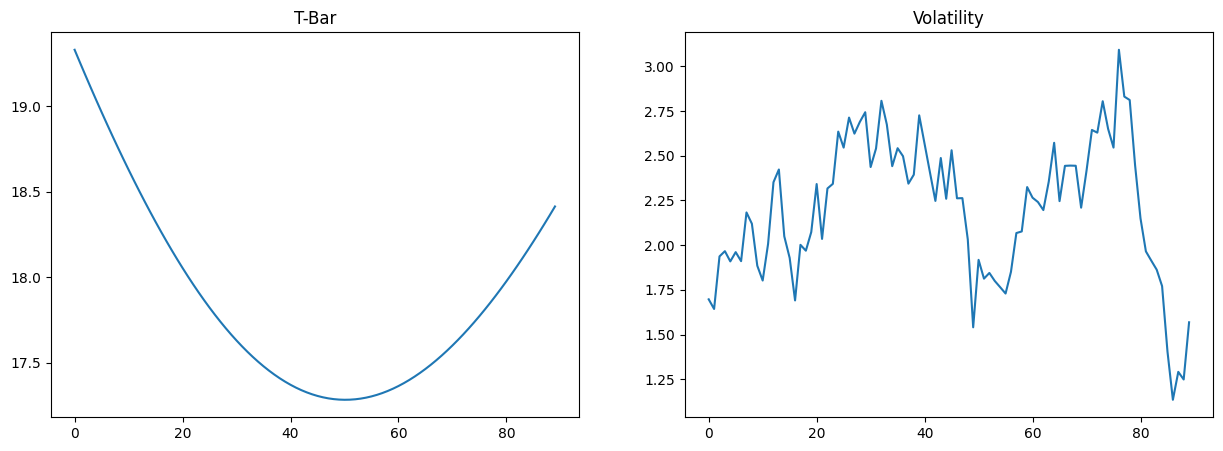

In [330]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=1)
t_bar, vol = tm.T_bar[1:], tm.sigma.flatten()[1:] #Exclude the first value (historical)

fig, axes = plt.subplots(ncols=2, figsize=(15,5))
axes[0].plot(t_bar)
axes[0].set_title('T-Bar')
axes[1].plot(vol)
axes[1].set_title('Volatility')
plt.show()

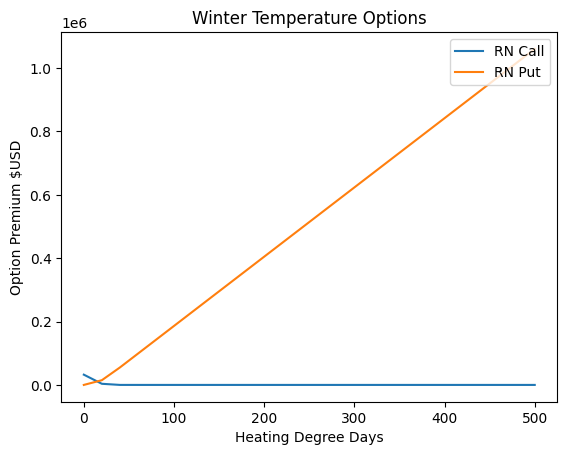

In [333]:
payoff, K, rf = 2500, 300, 0.05
rn = RiskNeutral(t)
mu, var = rn.compute_mean_var(t_bar, vol, 0)

strikes = np.arange(0,520,20)
data = np.zeros(shape=(len(strikes),2))
for i, strike in enumerate(strikes):
    data[i, 0] = rn.option_price('c', payoff, mu, var, strike, t, rf)
    data[i, 1] = rn.option_price('p', payoff, mu, var, strike, t, rf)

df = pd.DataFrame({'RN Call': data[:, 0], 'RN Put': data[:, 1]})
df.index = strikes
plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=1)
plt.show()

After a few guesses, the best estimate seems to $\lambda = 500$.

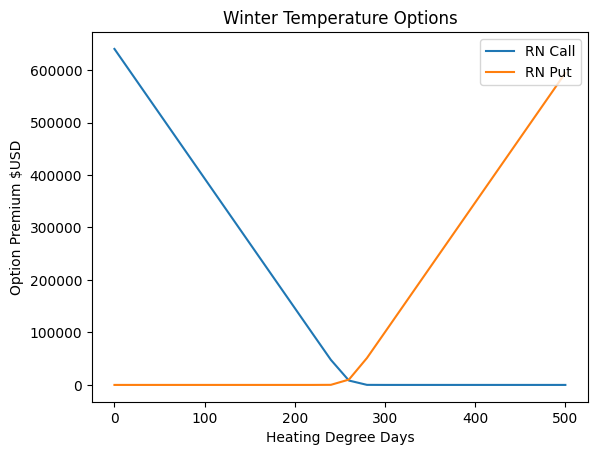

In [334]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=1000)
t_bar = tm.T_bar[1:]
vol = np.mean(tm.sigma, axis=0)[1:] #Get the average for stability

payoff, K, rf = 2500, 300, 0.05
lamda = 500
rn = RiskNeutral(t)
mu, var = rn.compute_mean_var(t_bar, vol, lamda)

strikes = np.arange(0,520,20)
data = np.zeros(shape=(len(strikes),2))
for i, strike in enumerate(strikes):
    data[i, 0] = rn.option_price('c', payoff, mu, var, strike, t, rf)
    data[i, 1] = rn.option_price('p', payoff, mu, var, strike, t, rf)

df = pd.DataFrame({'RN Call': data[:, 0], 'RN Put': data[:, 1]})
df.index = strikes
plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=1)
plt.show()

## Monte Carlo Method

In this method, we will not assume that the probability that the temperature goes above 18 is infinitesimally small.
$$H_n = \sum^n_{i=1}(18 - T_i)^+$$

Therefore, we have the following equations:
$$C_t = \alpha{e^{-r(T-t)}} (H_n-K)^+$$
$$P_t = \alpha{e^{-r(T-t)}} (K-H_n)^+$$

Using the Monte Carlo Simulation method:
$$C_t = \frac{{e^{-r(T-t)}}}{n}\sum^n_{i=1}\alpha(DD_i-K)^+$$
$$P_t = \frac{{e^{-r(T-t)}}}{n}\sum^n_{i=1}\alpha(K-DD_i)^+$$

In [349]:
class MonteCarlo:
    def total_degree_days(self, sims:np.array) -> np.array:
        degree_days = np.maximum(18-sims, 0)
        return np.sum(degree_days, axis=1) #HDD per path
    
    def option_price(self, option_type:str, hdd:np.array, payoff:int, strike:int, time_to_expiry:int, risk_free:float) -> float:
        tau = time_to_expiry/365
        decay_factor = np.exp(-risk_free*tau)
        
        if option_type == 'c':
            diff_strike = np.maximum(hdd-strike, 0)
        elif option_type == 'p':
            diff_strike = np.maximum(strike-hdd, 0)
        else:
            raise ValueError("Option type must either be 'c' or 'p'")
        
        return decay_factor*np.mean(payoff*diff_strike)

In [353]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=10000)[:, 1:]

payoff, K, rf = 2500, 300, 0.05
mc = MonteCarlo()
hdd = mc.total_degree_days(sims)
call = mc.option_price('c', hdd, payoff, K, t, rf)
call

np.float64(622.9980846835258)

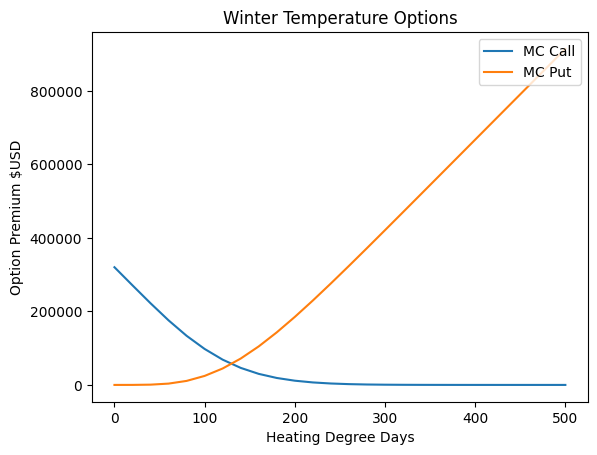

In [366]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=10000)[:, 1:]

payoff, rf = 2500, 0.05
mc = MonteCarlo()
hdd = mc.total_degree_days(sims)

strikes = np.arange(0,520,20)
data = np.zeros(shape=(len(strikes),2))
for i, strike in enumerate(strikes):
    data[i, 0] = mc.option_price('c', hdd, payoff, strike, t, rf)
    data[i, 1] = mc.option_price('p', hdd, payoff, strike, t, rf)

df = pd.DataFrame({'MC Call': data[:, 0], 'MC Put': data[:, 1]})
df.index = strikes
plt.plot(df)
plt.title('Winter Temperature Options')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=1)
plt.show()

Initially, the idea was to use the Risk-Neutral method as a baseline for our Monte-Carlo simulation method. However, that is not feasible due to the parameter $\lambda$. We can freely change this value to fit our needs. Nonetheless, with this we have successfully created two potential temperature option pricing model for Sydney, Australia.

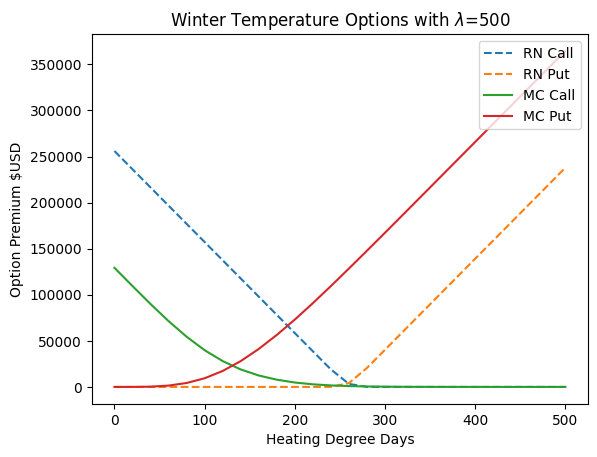

In [381]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=10000)[:, 1:]

#Risk-Neutral
t_bar = tm.T_bar[1:]
vol = np.mean(tm.sigma, axis=0)[1:]
lamda = 500
rn = RiskNeutral(t)
mu, var = rn.compute_mean_var(t_bar, vol, lamda)

#Monte-Carlo
mc = MonteCarlo()
hdd = mc.total_degree_days(sims)

payoff, rf = 1000, 0.05
strikes = np.arange(0,520,20)
data = np.zeros(shape=(len(strikes),4))
for i, strike in enumerate(strikes):
    data[i, 0] = rn.option_price('c', payoff, mu, var, strike, t, rf)
    data[i, 1] = rn.option_price('p', payoff, mu, var, strike, t, rf)
    data[i, 2] = mc.option_price('c', hdd, payoff, strike, t, rf)
    data[i, 3] = mc.option_price('p', hdd, payoff, strike, t, rf)

df = pd.DataFrame({
    'RN Call': data[:, 0], 'RN Put': data[:, 1],
    'MC Call': data[:, 2], 'MC Put': data[:, 3]})
df.index = strikes
plt.plot(df['RN Call'], linestyle='--')
plt.plot(df['RN Put'], linestyle='--')
plt.plot(df['MC Call'])
plt.plot(df['MC Put'])
plt.title(f'Winter Temperature Options with $\lambda$={lamda}')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=1)
plt.show()

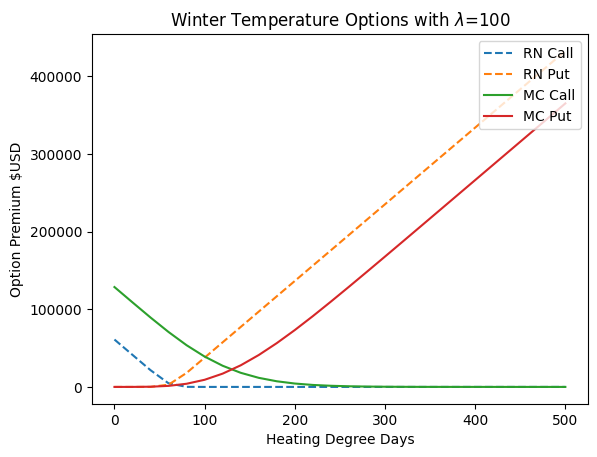

In [380]:
t = 90
tm = TemperatureModel(t_model, t)
sims = tm.temperature_ou_process(paths=10000)[:, 1:]

#Risk-Neutral
t_bar = tm.T_bar[1:]
vol = np.mean(tm.sigma, axis=0)[1:]
lamda = 100
rn = RiskNeutral(t)
mu, var = rn.compute_mean_var(t_bar, vol, lamda)

#Monte-Carlo
mc = MonteCarlo()
hdd = mc.total_degree_days(sims)

payoff, rf = 1000, 0.05
strikes = np.arange(0,520,20)
data = np.zeros(shape=(len(strikes),4))
for i, strike in enumerate(strikes):
    data[i, 0] = rn.option_price('c', payoff, mu, var, strike, t, rf)
    data[i, 1] = rn.option_price('p', payoff, mu, var, strike, t, rf)
    data[i, 2] = mc.option_price('c', hdd, payoff, strike, t, rf)
    data[i, 3] = mc.option_price('p', hdd, payoff, strike, t, rf)

df = pd.DataFrame({
    'RN Call': data[:, 0], 'RN Put': data[:, 1],
    'MC Call': data[:, 2], 'MC Put': data[:, 3]})
df.index = strikes
plt.plot(df['RN Call'], linestyle='--')
plt.plot(df['RN Put'], linestyle='--')
plt.plot(df['MC Call'])
plt.plot(df['MC Put'])
plt.title(f'Winter Temperature Options with $\lambda$={lamda}')
plt.ylabel('Option Premium $USD')
plt.xlabel('Heating Degree Days')
plt.legend(df.columns, loc=1)
plt.show()

# Model Limitations

1. As this project was to learn about time-series, there were a lot of gaps in knowledge. One of which was combining a continuous process with a discrete time component, in the end, we tried to model the temperature data as a modified OU with a time-varying volatility (modelled using OU) process. However in the modified OU process, we used an ARIMA(1,1,2) model that only functions in discrete time. Luckily in our case, since we are utilizing daily temperature, the ARIMA model is still a decent approximation.

2. Instead of using daily volatility, we used a 7-day rolling window to approximate the daily standard deviation due to the lack of intraday temperature data. Therefore, the parameters influenced by the volatility may not be entirely accurate and could have smoothing effects applied.

3. The Risk-Neutral calculation uses an arbitrary $\lambda$ estimated through trial and error. Therefore, it is not reflective of actual market conditions and needs to be properly calibrated to get a realistic estimate of option price.

4. With the absence of readily available Temperature Derivative data in Sydney, Australia, the current prices are merely estimates of the fair-value and further evaluation is required to gain confidence in the calculated prices. 